In [1]:
import pathlib
import tensorflow as tf
import tensorflow.keras.backend as K
import skimage

import imageio

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Makes it so any changes in pymedphys is automatically
# propagated into the notebook without needing a kernel reset.
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [3]:
from pymedphys._experimental.autosegmentation import unet

2021-01-18 21:07:17.190 INFO    blib2to3.pgen2.driver: Generating grammar tables from C:\Users\sbiggs\git\pymedphys\.venv\lib\site-packages\blib2to3\Grammar.txt
2021-01-18 21:07:17.233 INFO    blib2to3.pgen2.driver: Writing grammar tables to C:\Users\sbiggs\AppData\Local\black\black\Cache\19.10b0\Grammar3.7.9.final.0.pickle
2021-01-18 21:07:17.237 INFO    blib2to3.pgen2.driver: Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\sbiggs\\AppData\\Local\\black\\black\\Cache\\19.10b0\\tmp4hb7tgd8'
2021-01-18 21:07:17.241 INFO    blib2to3.pgen2.driver: Generating grammar tables from C:\Users\sbiggs\git\pymedphys\.venv\lib\site-packages\blib2to3\PatternGrammar.txt
2021-01-18 21:07:17.245 INFO    blib2to3.pgen2.driver: Writing grammar tables to C:\Users\sbiggs\AppData\Local\black\black\Cache\19.10b0\PatternGrammar3.7.9.final.0.pickle
2021-01-18 21:07:17.246 INFO    blib2to3.pgen2.driver: Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\sbiggs\\AppData\\Local\\bla

In [4]:
output_channels=3

In [72]:
model = unet.unet(grid_size=64, output_channels=output_channels)  # background, patient, brain, eyes

# tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
model

In [7]:
structure_uids = [
    path.name for path in pathlib.Path('data').glob('*')
]

structure_uids

['1.2.840.113704.1.111.2112',
 '1.2.840.113704.1.111.2128',
 '1.2.840.113704.1.111.2288',
 '1.2.840.113704.1.111.2352',
 '1.2.840.113704.1.111.2556',
 '1.2.840.113704.1.111.2724',
 '1.2.840.113704.1.111.3096',
 '1.2.840.113704.1.111.3120',
 '1.2.840.113704.1.111.3156',
 '1.2.840.113704.1.111.3616',
 '1.2.840.113704.1.111.3852',
 '1.2.840.113704.1.111.3880',
 '1.2.840.113704.1.111.3940',
 '1.2.840.113704.1.111.4000']

In [8]:
split_num = len(structure_uids) - 2
training_uids = structure_uids[0:split_num]
testing_uids = structure_uids[split_num:]

In [9]:
training_uids

['1.2.840.113704.1.111.2112',
 '1.2.840.113704.1.111.2128',
 '1.2.840.113704.1.111.2288',
 '1.2.840.113704.1.111.2352',
 '1.2.840.113704.1.111.2556',
 '1.2.840.113704.1.111.2724',
 '1.2.840.113704.1.111.3096',
 '1.2.840.113704.1.111.3120',
 '1.2.840.113704.1.111.3156',
 '1.2.840.113704.1.111.3616',
 '1.2.840.113704.1.111.3852',
 '1.2.840.113704.1.111.3880']

In [10]:
testing_uids

['1.2.840.113704.1.111.3940', '1.2.840.113704.1.111.4000']

In [11]:
def get_image_paths_for_uids(uids):
    image_paths = [
        str(path) for path in pathlib.Path('data').glob('**/*_image.png')
        if not path.parent.name in uids
    ]
    np.random.shuffle(image_paths)
    
    return image_paths


def mask_paths_from_image_paths(image_paths):
    mask_paths = [
        f"{image_path.split('_')[0]}_mask.png"
        for image_path in image_paths
    ]
    
    return mask_paths

In [12]:
training_image_paths = get_image_paths_for_uids(training_uids)
training_mask_paths = mask_paths_from_image_paths(training_image_paths)

testing_image_paths = get_image_paths_for_uids(testing_uids)
testing_mask_paths = mask_paths_from_image_paths(testing_image_paths)

In [13]:
# training_image_paths

In [14]:

# mask_paths

In [15]:
# mask_weights = np.array([
#     0.9864694074789978, 0.9251728496022601, 0.0883577429187421
# ])[None, None, :]

In [19]:
def _normalise_mask(png_mask):
    normalised_mask = np.round(png_mask / 255).astype(float)
    
    return normalised_mask

In [20]:
# def _remove_mask_weights(weighted_mask):
#     return weighted_mask / mask_weights
    
 

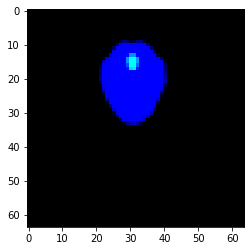

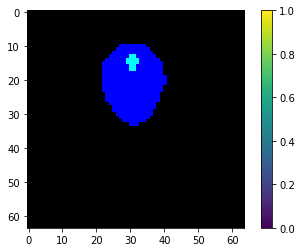

In [21]:
png_mask = imageio.imread(testing_mask_paths[0])
normalised_mask = _normalise_mask(png_mask)
plt.imshow(png_mask)
plt.show()
plt.imshow(normalised_mask)
plt.colorbar()

In [22]:
normalised_mask.shape

(64, 64, 3)

In [23]:
np.max(normalised_mask[:,:,0])

0.0

In [24]:
np.max(normalised_mask[:,:,1])

1.0

In [25]:
np.max(normalised_mask[:,:,2])

1.0

In [26]:
def _normalise_image(png_image):
    normalised_image = png_image[:,:,None].astype(float) / 255
    return normalised_image

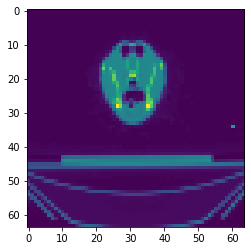

In [27]:
input_array = _normalise_image(imageio.imread(testing_image_paths[0]))
plt.imshow(input_array)

In [28]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 200

def get_dataset(image_paths, mask_paths):
    input_arrays = []
    output_arrays = []
    for image_path, mask_path in zip(image_paths, mask_paths):
        input_arrays.append(_normalise_image(imageio.imread(image_path)))
        output_arrays.append(_normalise_mask(imageio.imread(mask_path)))
        
    dataset = tf.data.Dataset.from_tensor_slices((input_arrays, output_arrays))
    dataset = dataset.repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    
    return dataset

In [29]:
training_dataset = get_dataset(training_image_paths, training_mask_paths)
testing_dataset = get_dataset(testing_image_paths, testing_mask_paths)

In [30]:
for image, mask in training_dataset.take(1):
    sample_image_raw, sample_mask_raw = image, mask

has_brain = np.sum(sample_mask_raw[:,:,:,1], axis=(1,2))
has_eyes = np.sum(sample_mask_raw[:,:,:,0], axis=(1,2))

max_brain_eyes_combo = np.argmax(has_brain * has_eyes)

sample_image = sample_image_raw[max_brain_eyes_combo,:,:,:]
sample_mask = sample_mask_raw[max_brain_eyes_combo,:,:,:]

In [86]:
np.sum(sample_mask_raw[:,:,:,0])

477.0

In [89]:
np.sum(sample_mask_raw[:,:,:,0]==0) / np.sum(sample_mask_raw[:,:,:,0])

1098.1362683438156

In [31]:
# scharr_operators 

In [32]:
# sch_mag = np.sqrt(sum([scharr(image, axis=i)**2
#                        for i in range(image.ndim)]) / image.ndim)

In [33]:
def _add_channels(kernel, output_channels, batch_size):
    kernel = np.concatenate([kernel[:,:,None],]*output_channels, axis=-1)
#     kernel = np.concatenate([kernel[None,:,:,:],]*batch_size, axis=0)
    return kernel

In [34]:
scharr_x = np.array([
    [47, 0, -47],
    [162, 0, -162],
    [47, 0, -47]
]).astype(np.float32)
scharr_y = scharr_x.T
scharr_x = K.constant(scharr_x)
scharr_y = K.constant(scharr_y)


# scharr_x = _add_channels(scharr_x, output_channels, BATCH_SIZE)
# scharr_y = _add_channels(scharr_y, output_channels, BATCH_SIZE)

In [35]:
sample_mask_raw.shape

TensorShape([128, 64, 64, 3])

In [36]:
sample_mask_raw[0,:,:,2][None,:,:,None].shape

TensorShape([1, 64, 64, 1])

In [37]:
scharr_x[None,:,:,None].shape

TensorShape([1, 3, 3, 1])

In [38]:
# dir(K)

In [39]:
def _apply_sharr_filter(image):
    items = []
    for i in range(image.shape[-1]):
        x = tf.compat.v1.nn.convolution(image[:,:,:,i][:,:,:,None], scharr_x[:,:,None,None], padding="VALID")
        y = tf.compat.v1.nn.convolution(image[:,:,:,i][:,:,:,None], scharr_y[:,:,None,None], padding="VALID")
        items.append(K.sqrt(x**2 + y**2))
        
    return K.concatenate(items, axis=-1)

In [40]:
image = K.constant(tf.cast(sample_mask_raw, tf.float32))

In [41]:
filtered = _apply_sharr_filter(image)

In [42]:
# K.conv1d?

In [43]:
# def _apply_kernel(image, kernel):
#     return K.conv2d(image[0:1,:,:,2:], kernel[:,:,None], padding="same", data_format='channels_last', dilation_rate=1, strides=1)

In [44]:
# x_dir = _apply_kernel(sample_mask_raw, scharr_x)
# y_dir = _apply_kernel(sample_mask_raw, scharr_y)

# magnitude = K.sqrt(x_dir**2 + y_dir**2)

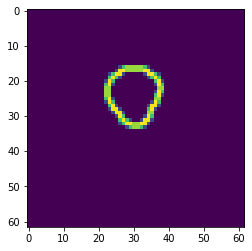

In [45]:
plt.imshow(filtered[0,:,:,2])

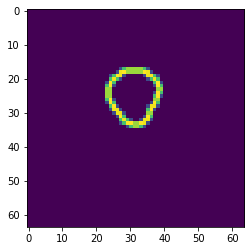

In [46]:
edge_reference = skimage.filters.scharr(sample_mask_raw[0,:,:,2])
plt.imshow(edge_reference)

In [47]:
def skimage_scharr_loss(reference, evaluation):
    edge_reference = skimage.filters.scharr(reference)
    edge_evaluation = skimage.filters.scharr(evaluation)

    score = np.sum(np.abs(edge_evaluation - edge_reference)) / np.sum(
        edge_evaluation + edge_reference
    )
    
    return score

In [48]:
custom_weights = [0.98, 0.92, 0.08]

In [49]:
def scharr_loss(reference, evaluation):
    edge_reference = _apply_sharr_filter(reference)
    edge_evaluation = _apply_sharr_filter(evaluation)

    score = 0
    for i in range(edge_evaluation.shape[-1]):
        score += custom_weights[i] * K.sum(K.abs(edge_evaluation[:,:,:,i] - edge_reference[:,:,:,i]))
    
    return score

In [50]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [93]:
cross_entropy_weights = []
for i in range(3):
    num_of_ones = np.sum(sample_mask_raw[:,:,:,i])
    num_of_zeros = np.sum(sample_mask_raw[:,:,:,i]==0)
    
    one_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
    zero_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)
    
    cross_entropy_weights.append([one_weight, zero_weight])                                

In [104]:
def weighted_cross_entropy(y_true, y_pred):
    loss = 0
    for i in range(y_pred.shape[-1]):
        one_weight, zero_weight = cross_entropy_weights[i]
        b_ce = K.binary_crossentropy(y_true[:,:,:,i], y_pred[:,:,:,i])
        
        weight_vector = y_true[:,:,:,i] * one_weight + (1 - y_true[:,:,:,i]) * zero_weight
        loss += K.mean(weight_vector * b_ce)
        
    return loss

In [105]:
scharr_loss(image, image)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [106]:
# sample_mask

In [107]:
# total_class_weight_normalisation = 1/4 * (
#     number_of_not_background + number_of_not_patient + number_of_not_brain + number_of_not_eyes)

# class_weights = [
#     number_of_not_background / total_class_weight_normalisation,
#     number_of_not_patient / total_class_weight_normalisation,
#     number_of_not_brain / total_class_weight_normalisation,
#     number_of_not_eyes / total_class_weight_normalisation
# ]

# class_weights

In [108]:
import tensorflow.keras.backend as K



In [109]:
model.compile(
    optimizer='adam',
    loss=weighted_cross_entropy,
    metrics=['accuracy']
)

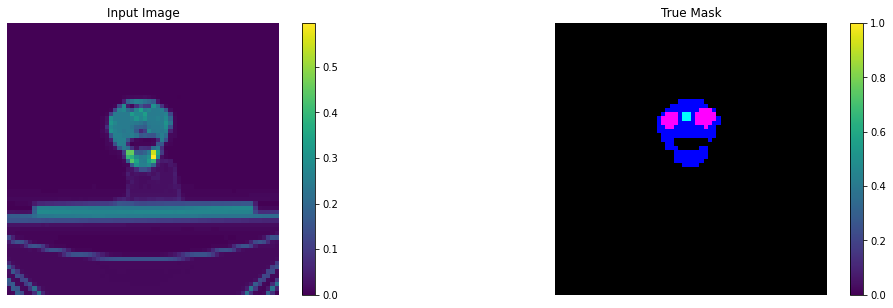

In [110]:
def display(display_list):
    plt.figure(figsize=(18, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])            
        plt.imshow(display_list[i])
        plt.colorbar()
        plt.axis('off')
        
    plt.show()
    
display([sample_image, sample_mask])

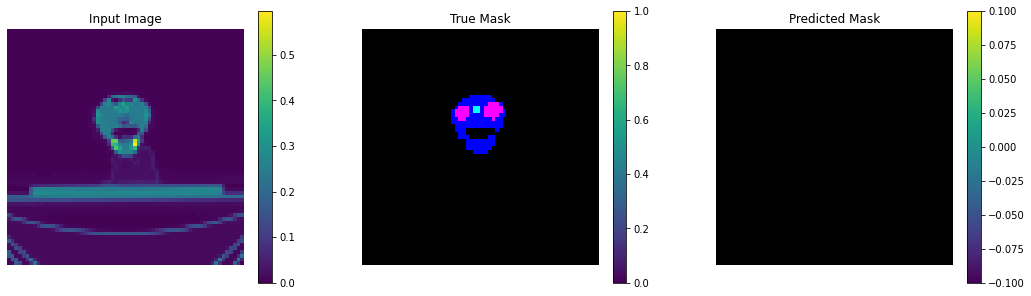

In [111]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])
    else:
        display(
            [
                sample_image, sample_mask,
                model.predict(sample_image[tf.newaxis, ...])[0]
            ]
        )
        
show_predictions()

In [112]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/1000
1/1 [==============================] - 15s 15s/step - loss: -0.0526 - accuracy: 0.9533


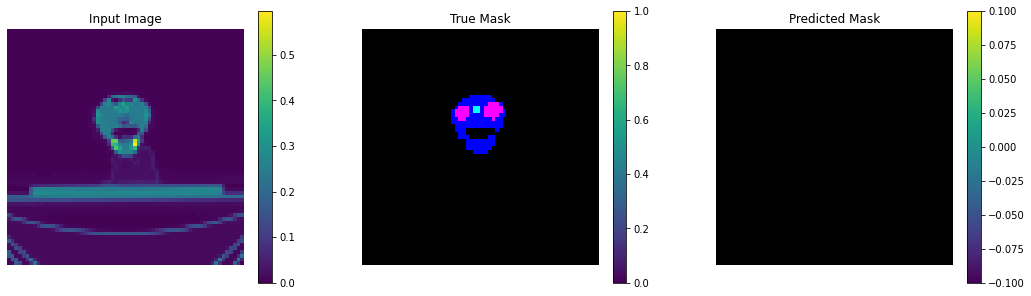


Sample Prediction after epoch 1

Epoch 2/1000
1/1 [==============================] - 14s 14s/step - loss: -0.0728 - accuracy: 0.9521


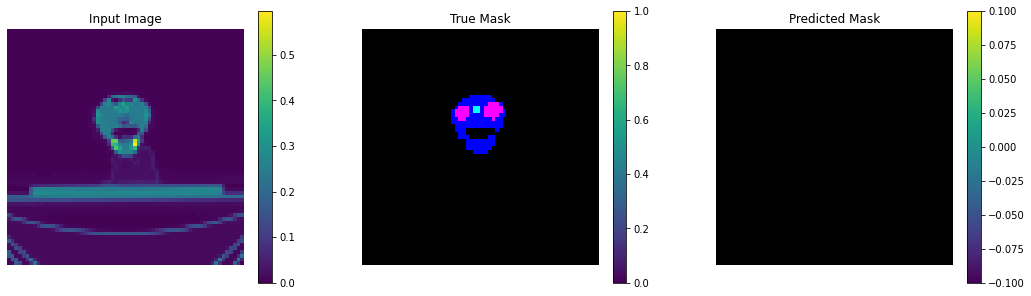


Sample Prediction after epoch 2

Epoch 3/1000


In [ ]:
model_history = model.fit(
    training_dataset, epochs=1000,
    steps_per_epoch=10,
    callbacks=[DisplayCallback()],
)